<a href="https://colab.research.google.com/github/Naveenchander1997/Traffic-Signs-Recognition-Using-Pytorch/blob/main/Traffic_Signs_Recognition_By_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2021-05-06 07:48:37--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip.2’

GTSRB_Final_Trainin 100%[===================>] 263.50M  19.1MB/s    in 15s     

2021-05-06 07:48:53 (17.5 MB/s) - ‘GTSRB_Final_Training_Images.zip.2’ saved [276294756/276294756]



In [ ]:
!unzip -qq GTSRB_Final_Training_Images.zip

replace GTSRB/Final_Training/Images/00000/00000_00000.ppm? [y]es, [n]o, [A]ll, [N]one, [r]ename: All


###Exploration of data

In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(16, 8))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')

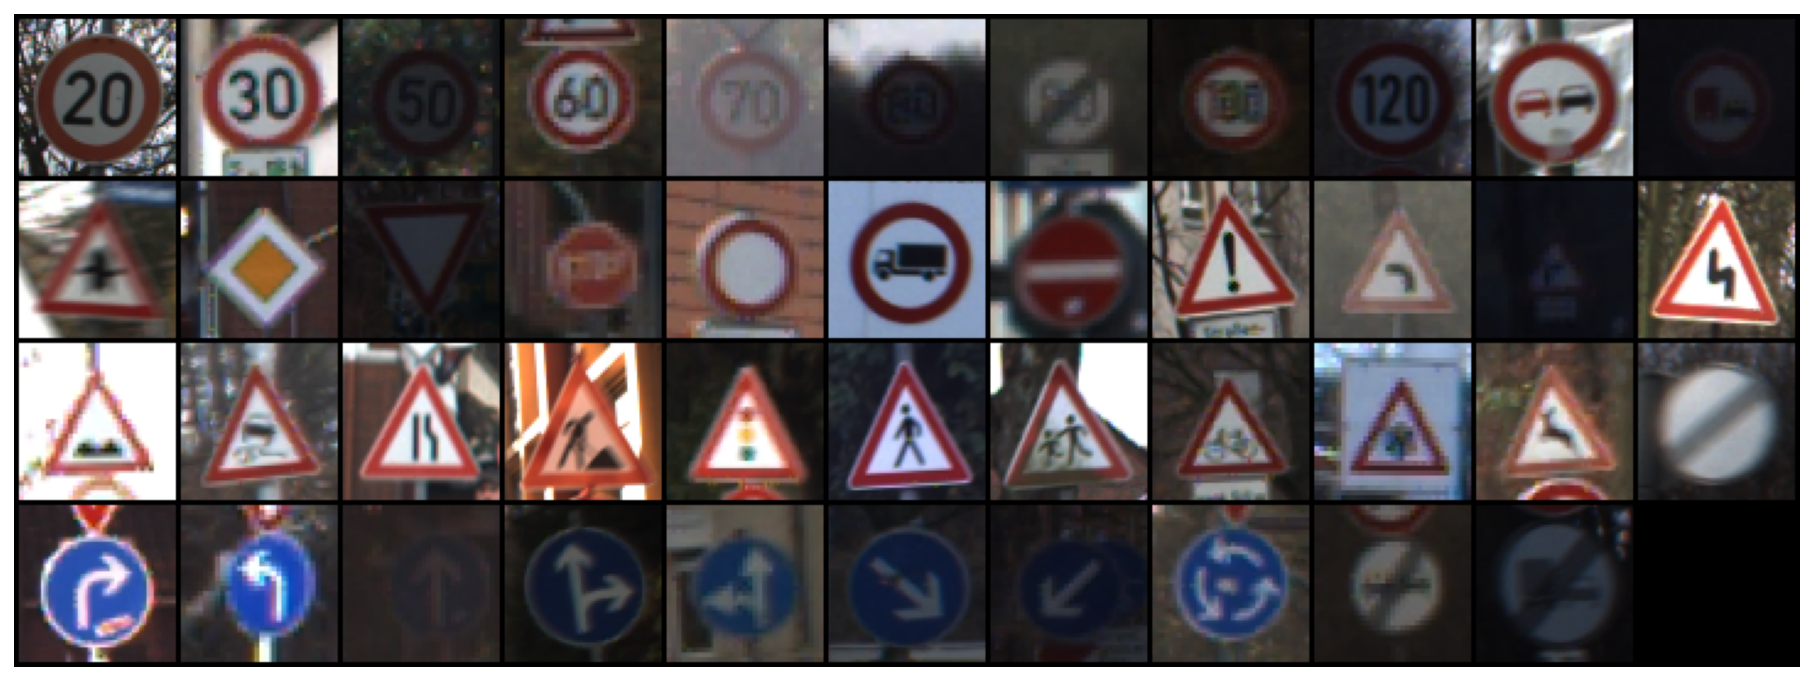

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

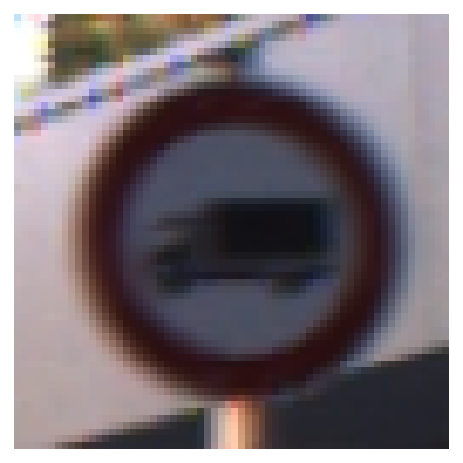

In [ ]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]
show_image(img_path)

###Building a dataset

In [ ]:
class_names = ['speed_limit 30','prohibitory signs','crossroads ahead','priority_road', 'give_way', 'stop', 'no_entry','no_left turn','speed_limit 50','no_right turn','uneven_road','slippery_road','road_work','Turn_right ahead','Turn_left ahead','Roundabout']
class_indices = [1,10,11,12, 13, 14, 17,19,2,20,22,23,25,33,34,40]

In [ ]:
!rm -rf data
DATA_DIR = Path('data')
DATASETS = ['train', 'val', 'test']
for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

We’ll reserve 80% of the images for training, 10% for validation, and 10% test for each class. We’ll copy each image to the correct dataset directory:

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)
  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )
  dataset_data = zip(DATASETS, ds_split)
  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

speed_limit 30: 2220
prohibitory signs: 2010
crossroads ahead: 1320
priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110
no_left turn: 210
speed_limit 50: 2250
no_right turn: 360
uneven_road: 390
slippery_road: 510
road_work: 1500
Turn_right ahead: 689
Turn_left ahead: 420
Roundabout: 360


We have some class imbalance, but it is not that bad. We’ll ignore it.

We’ll apply some image augmentation techniques to artificially increase the size of our training dataset:

#create Transformations

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

We apply some random resizing, rotation, and horizontal flips. Finally, we normalize the tensors using preset values for each channel. This is a requirement of the pre-trained models in Torchvision.

We’ll create a PyTorch dataset for each image dataset folder and data loaders for easier training:

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}
data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We’ll also store the number of examples in each dataset and class names for later:

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

{'test': 1839, 'train': 14711, 'val': 1839}

Let’s have a look at some example images with applied transformations. We also need to reverse the normalization and reorder the color channels to get correct image data:

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


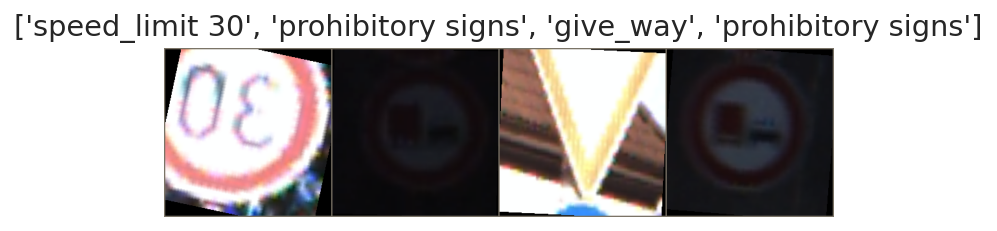

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

###Using a pre-trained model:

Here, we’ll use Transfer Learning to copy the architecture of the very popular ResNet model. On top of that, we’ll use the learned weights of the model from training on the ImageNet dataset . All of this is made easy to use by Torchvision:

In [ ]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)
  return model.to(device)

We reuse almost everything except the change of the output layer. This is needed because the number of classes in our dataset is different than ImageNet.

Let’s create an instance of our model:

In [ ]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


##Training
We’ll write 3 helper functions to encapsulate the training and evaluation logic. Let’s start with train_epoch:

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  scheduler.step()
  return correct_predictions.double() / n_examples, np.mean(losses)

We start by turning our model into train mode and go over the data. After getting the predictions, we get the class with maximum probability along with the loss, so we can calculate the epoch loss and accuracy.

Note that we’re also using a learning rate scheduler (more on that later).

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

The evaluation of the model is pretty similar, except that we don’t do any gradient calculations.

Let’s put everything together:

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=10):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)
  history = defaultdict(list)
  best_accuracy = 0
  for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc
  print(f'Best val accuracy: {best_accuracy}')
  model.load_state_dict(torch.load('best_model_state.bin'))
  return model, history

We do a lot of string formatting and recording of the training history. The hard stuff gets delegated to the previous helper functions. We also want the best model, so the weights of the most accurate model(s) get stored during the training.

Let’s train our first model:

In [ ]:
%%time
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Val   loss 0.08112452382536944 accuracy 0.9722675367047308

Epoch 2/10
----------
Train loss 0.31498662659555704 accuracy 0.8909659438515397
Val   loss 0.08453468889247814 accuracy 0.9700924415443175

Epoch 3/10
----------
Train loss 0.25580039948257627 accuracy 0.9121745632519883
Val   loss 0.07852063539790818 accuracy 0.9695486677542141

Epoch 4/10
----------
Train loss 0.21903409762661907 accuracy 0.9234586363945347
Val   loss 0.07282560154222478 accuracy 0.9722675367047308

Epoch 5/10
----------
Train loss 0.2064787143158986 accuracy 0.9276051933926993
Val   loss 0.03868270014997271 accuracy 0.9853181076672104

Epoch 6/10
----------
Train loss 0.18465979830014703 accuracy 0.9331112772755081
Val   loss 0.05386616200019158 accuracy 0.977705274605764

Epoch 7/10
----------
Train loss 0.18620145460656892 accuracy 0.9349466385697778
Val   loss 0.06366885774464752 accuracy 0.9782490483958672

Epoch 8/10
----------
Train loss 0.1447587543760752 accuracy 0.9484059547277548
Val   loss 0.014

Here’s a little helper function that visualizes the training history for us:

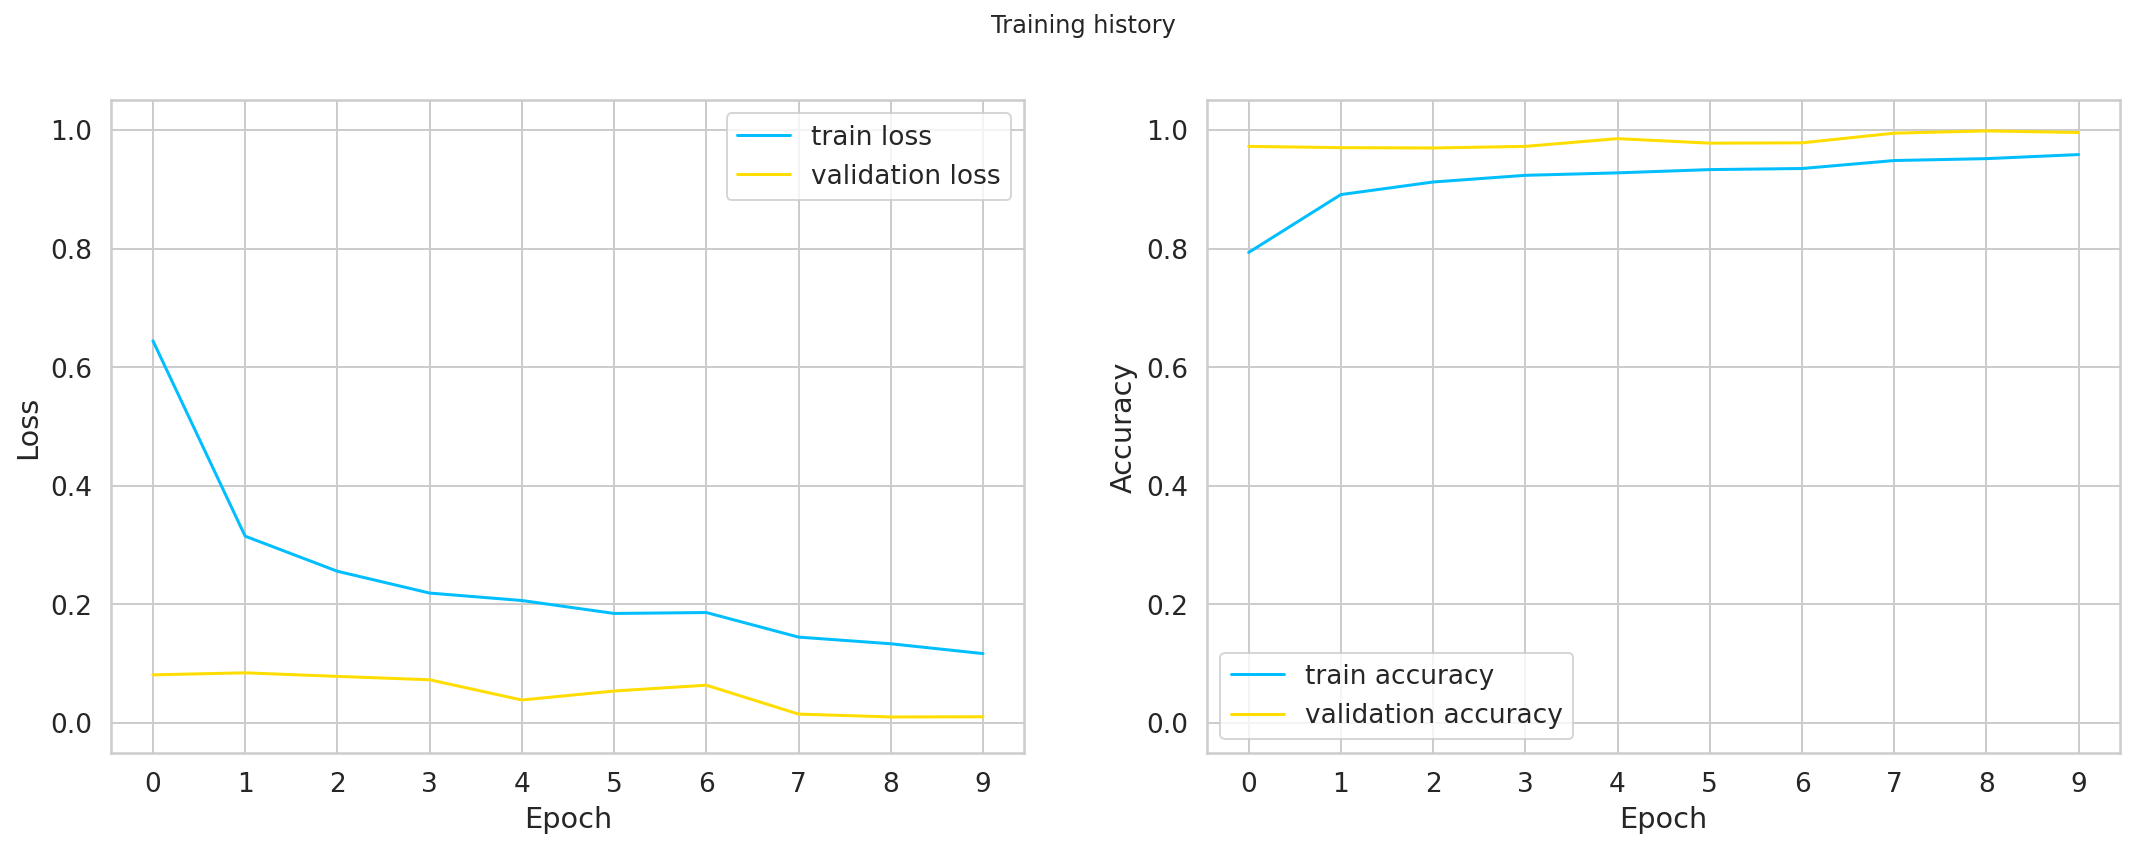

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  fig.suptitle('Training history')
plot_training_history(history)

The pre-trained model is so good that we get very high accuracy and low loss after 10 epochs. Unfortunately, our validation set is too small to get some meaningful metrics from it.

##Evaluation
Let’s see some predictions on traffic signs from the test set:

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


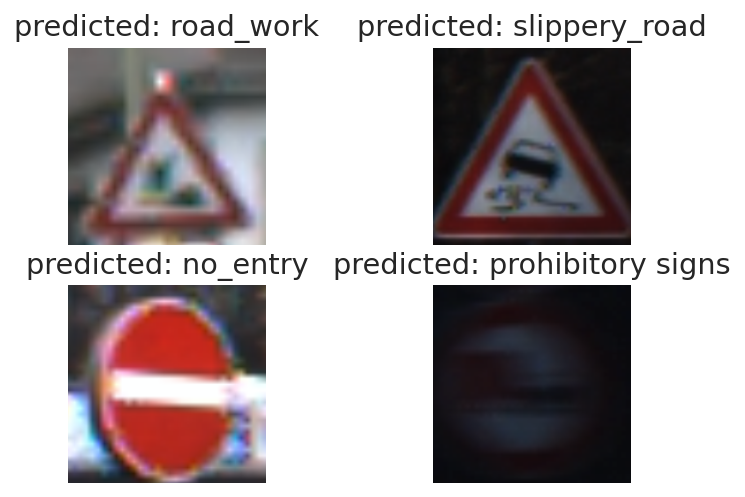

In [ ]:
show_predictions(base_model, class_names, n_images=4)

Very good! Even the almost not visible priority road sign is classified correctly. Let’s dive a bit deeper.

We’ll start by getting the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])
print(classification_report(y_test, y_pred, target_names=class_names))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


                   precision    recall  f1-score   support

       Roundabout       1.00      1.00      1.00        36
  Turn_left ahead       0.98      0.95      0.96        42
 Turn_right ahead       0.97      0.99      0.98        69
 crossroads ahead       1.00      1.00      1.00       132
         give_way       1.00      1.00      1.00       216
         no_entry       1.00      1.00      1.00       111
     no_left turn       0.95      1.00      0.98        21
    no_right turn       1.00      0.97      0.99        36
    priority_road       1.00      1.00      1.00       210
prohibitory signs       1.00      1.00      1.00       201
        road_work       0.99      1.00      1.00       150
    slippery_road       1.00      1.00      1.00        51
   speed_limit 30       1.00      1.00      1.00       222
   speed_limit 50       1.00      1.00      1.00       225
             stop       1.00      1.00      1.00        78
      uneven_road       1.00      1.00      1.00       

##Classifying unseen images
Ok, but how good our model will be when confronted with a real-world image? Let’s check it out:

In [ ]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 29.4MB/s]


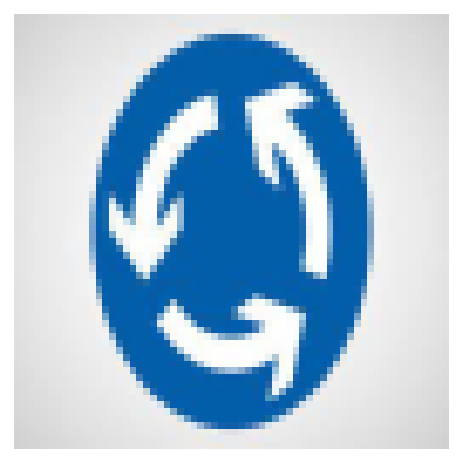

In [ ]:
show_image('/content/drive/MyDrive/Colab Notebooks/Roundabout.jpg')

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)
  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
pred = predict_proba(base_model, '/content/drive/MyDrive/Colab Notebooks/Roundabout.jpg')
pred

array([1.00000000e+00, 3.30875494e-10, 1.82255944e-09, 1.73512915e-09,
       1.16886945e-10, 3.77114572e-12, 7.86366686e-13, 7.45375224e-13,
       1.51169051e-12, 1.11994485e-11, 1.31158146e-13, 6.64577681e-12,
       3.03444145e-11, 4.17671269e-13, 1.27079976e-12, 3.44721799e-12],
      dtype=float32)

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

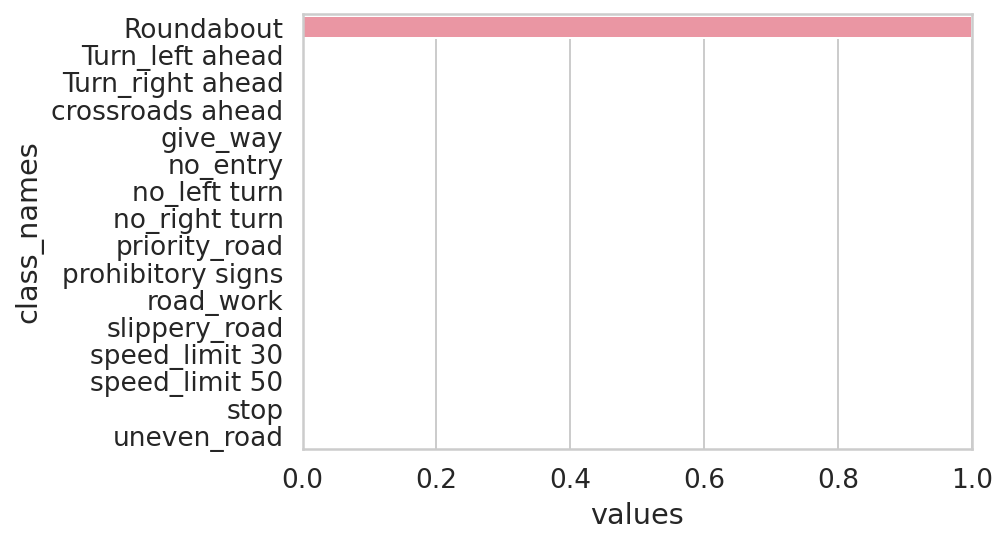

In [ ]:
show_prediction_confidence(pred, class_names)

##Classyfing unknown traffic sign
The last challenge for our model is a traffic sign that it hasn’t seen before:

In [ ]:
!gdown --id 1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u

Downloading...
From: https://drive.google.com/uc?id=1F61-iNhlJk-yKZRGcu6S9P29HxDFxF0u
To: /content/unknown-sign.jpg
100% 41.4k/41.4k [00:00<00:00, 38.8MB/s]


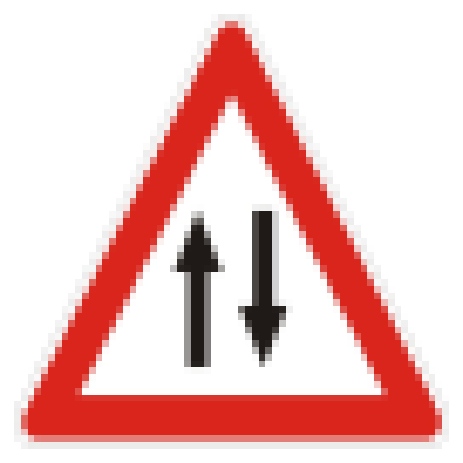

In [ ]:
show_image('unknown-sign.jpg')

Let’s get the predictions:

In [ ]:
pred = predict_proba(base_model, 'unknown-sign.jpg')
pred

array([1.3821835e-05, 7.3235722e-05, 2.6128757e-06, 3.5709612e-02,
       1.3021436e-01, 1.3597740e-05, 3.1540375e-03, 1.4604053e-03,
       7.9875987e-05, 1.2519062e-05, 5.1970607e-01, 2.4183619e-01,
       1.3160539e-02, 4.7438038e-03, 3.4361723e-04, 4.9475718e-02],
      dtype=float32)

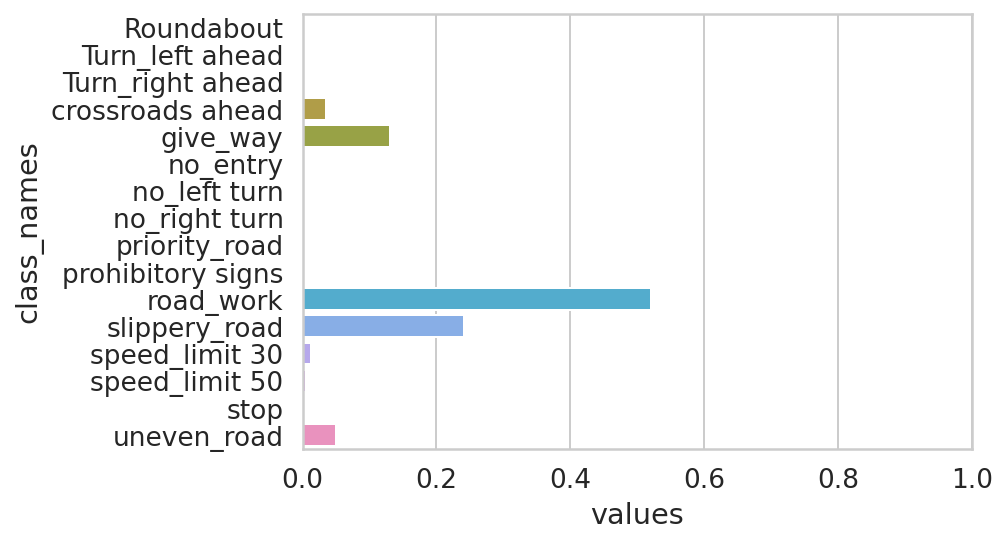

In [ ]:
show_prediction_confidence(pred, class_names)

This is obviously wrong. How can you make your model see this?

##Adding class “unknown”
While there are a variety of ways to handle this situation (one described in this paper: A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks), we’ll do something simpler.

We’ll get the indices of all traffic signs that weren’t included in our original dataset:

In [ ]:
unknown_indices = [
  i for i, f in enumerate(train_folders) \
  if i not in class_indices
]
len(unknown_indices)

27

We’ll create a new folder for the unknown class and copy some of the images there:

In [ ]:
for ds in DATASETS:
  (DATA_DIR / ds / 'unknown').mkdir(parents=True, exist_ok=True)
for ui in unknown_indices:
  image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
  image_paths = np.random.choice(image_paths, 50)
  ds_split = np.split(
    image_paths,
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )
  dataset_data = zip(DATASETS, ds_split)
  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/unknown/')

The next steps are identical to what we’ve already done:

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}
data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4)
  for d in DATASETS
}
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'test': 1958, 'train': 15298, 'val': 1960}

In [ ]:
%%time
enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.728319754935664 accuracy 0.7738920120277161
Val   loss 0.12469259392193673 accuracy 0.9535714285714286

Epoch 2/10
----------
Train loss 0.3690807420977245 accuracy 0.8749509739835273
Val   loss 0.1509889421883625 accuracy 0.9443877551020409

Epoch 3/10
----------
Train loss 0.3217410809790154 accuracy 0.8909661393646229
Val   loss 0.08973183555173589 accuracy 0.9755102040816327

Epoch 4/10
----------
Train loss 0.27105779505797034 accuracy 0.911034122107465
Val   loss 0.05962290496458051 accuracy 0.9724489795918368

Epoch 5/10
----------
Train loss 0.24433486522614878 accuracy 0.917113348150085
Val   loss 0.07565723169569104 accuracy 0.9770408163265307

Epoch 6/10
----------
Train loss 0.2308662118762332 accuracy 0.9233886782585959
Val   loss 0.054880523852859554 accuracy 0.9826530612244899

Epoch 7/10
----------
Train loss 0.20244719404564201 accuracy 0.930775264740489
Val   loss 0.07803313945548514 accuracy 0.9739795918367348

Epoch 8/10
----------
Train loss 0.17363170

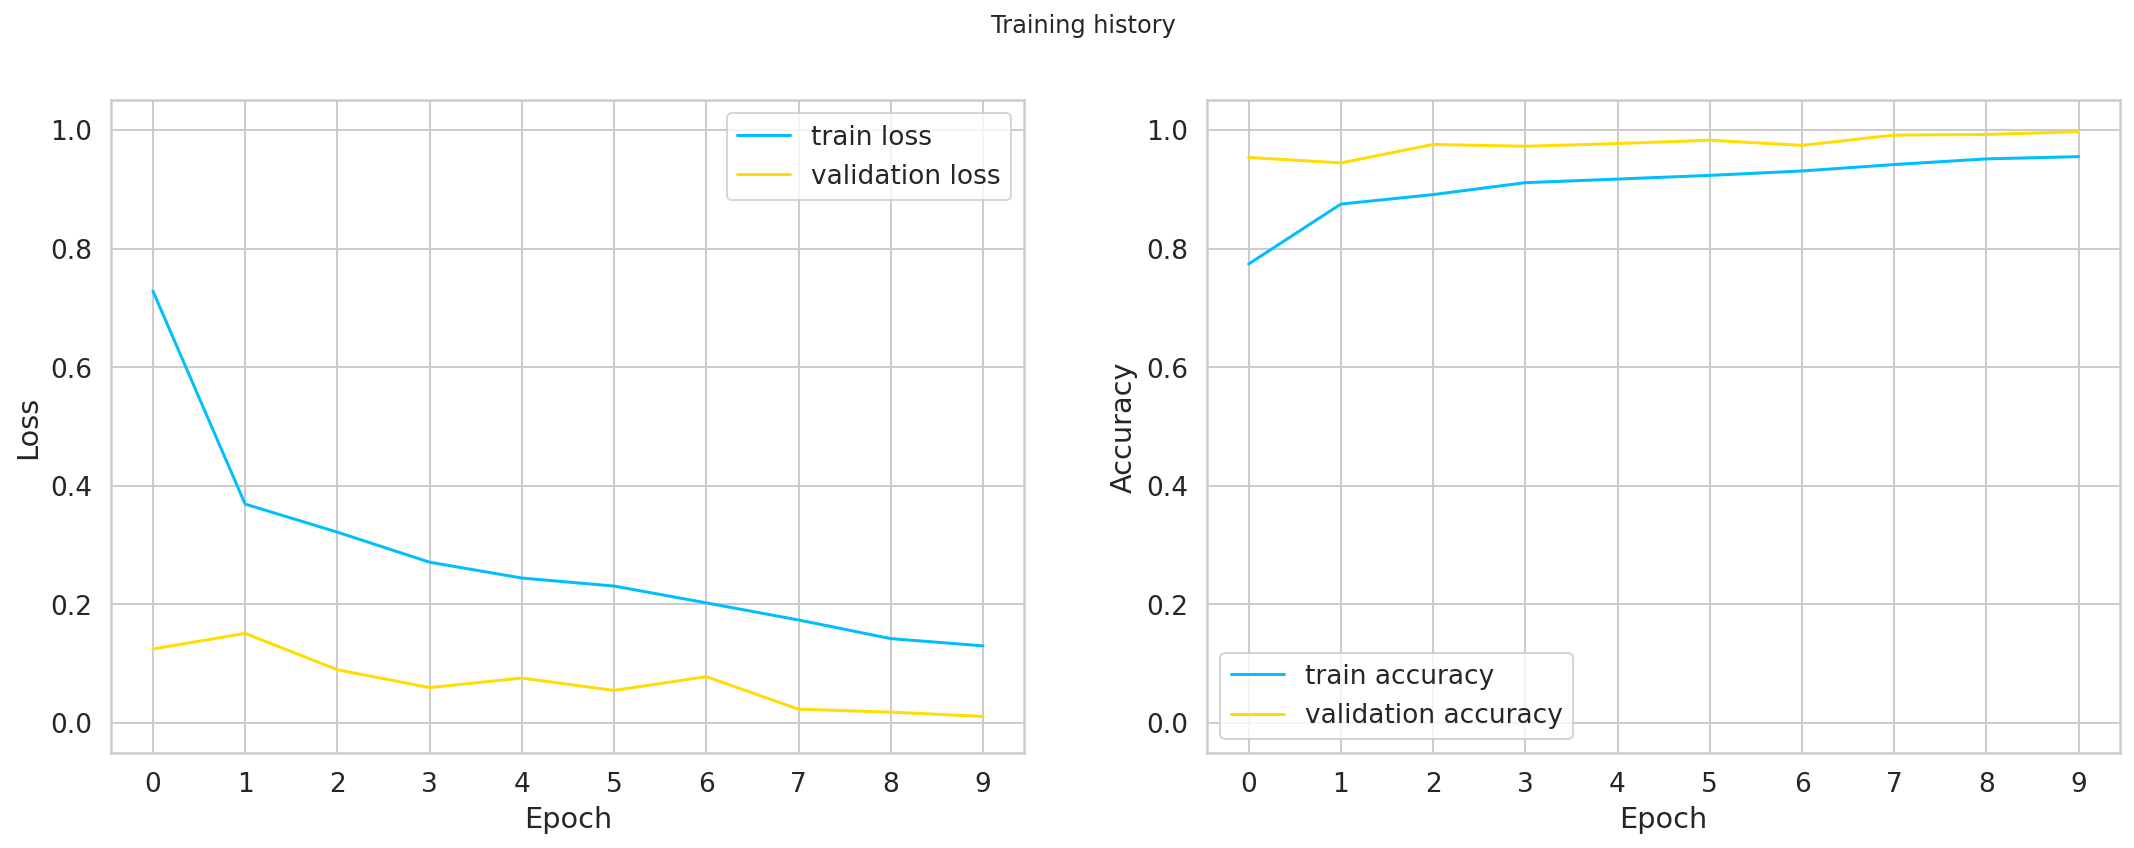

In [ ]:
plot_training_history(history)

Again, our model is learning very quickly. Let’s have a look at the sample image again:

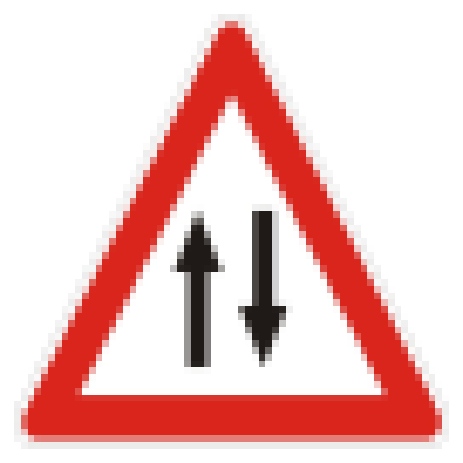

In [ ]:
show_image('unknown-sign.jpg')

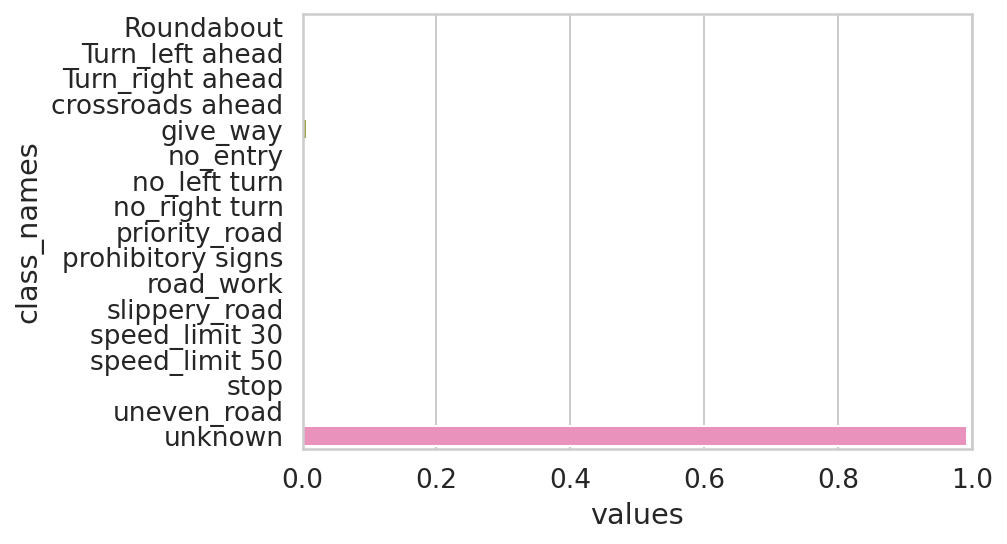

In [ ]:
pred = predict_proba(enchanced_model, 'unknown-sign.jpg')
show_prediction_confidence(pred, class_names)

Great, the model doesn’t give much weight to any of the known classes. It doesn’t magically know that this is a two-way sign, but recognizes is as unknown.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


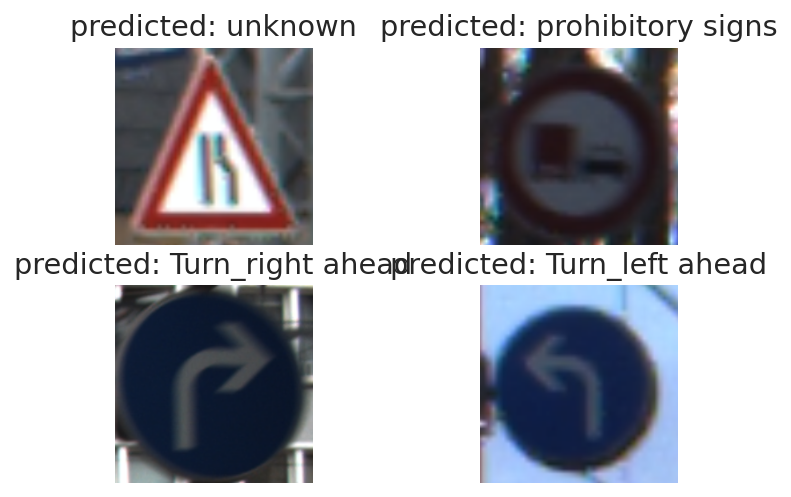

In [ ]:
show_predictions(enchanced_model, class_names, n_images=4)

Let’s get an overview of the new model’s performance:

In [ ]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])
print(classification_report(y_test, y_pred, target_names=class_names))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


                   precision    recall  f1-score   support

       Roundabout       0.97      1.00      0.99        36
  Turn_left ahead       0.95      1.00      0.98        42
 Turn_right ahead       1.00      0.96      0.98        69
 crossroads ahead       0.99      1.00      1.00       132
         give_way       1.00      0.99      1.00       216
         no_entry       1.00      1.00      1.00       111
     no_left turn       1.00      1.00      1.00        21
    no_right turn       1.00      1.00      1.00        36
    priority_road       1.00      1.00      1.00       210
prohibitory signs       1.00      1.00      1.00       201
        road_work       0.99      1.00      1.00       150
    slippery_road       1.00      1.00      1.00        51
   speed_limit 30       1.00      1.00      1.00       222
   speed_limit 50       1.00      1.00      1.00       225
             stop       1.00      1.00      1.00        78
      uneven_road       1.00      1.00      1.00       

###Summary
Good job! You trained two different models for classifying traffic signs from raw pixels. You also built a dataset that is compatible with Torchvision.

Run the notebook in your browser (Google Colab)
Read the Getting Things Done with Pytorch book
Here’s what you’ve learned:

Overview of the traffic sign image dataset
Build a dataset
Use a pre-trained model from Torchvision
Add a new unknown class and re-train the model